In [68]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

In [69]:
IMAGE_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_test/images"
#LABEL_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_0/annos"

In [70]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [71]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}


In [72]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [73]:
print("Sample PNG paths:", list(pngs)[:5])

Sample PNG paths: ['ID224_image1663635656796.png', 'ID226_image1663635822674.png', 'ID225_image1663635713278.png', 'ID166_image1662513979006.png', 'ID226_image1663635792796.png']


In [74]:
len(pngs)

288

In [75]:
pngs = sorted(pngs)

In [76]:
df_input = pd.read_csv('./output_9750.csv')

In [77]:
pngs[0].split('_')[1]

'image1661319116107.png'

In [78]:
image_dict = {name.split("_")[1]:name for name in list(pngs)}


In [79]:
df_input["image_path"] = df_input['image_name'].apply(lambda x: image_dict[x])

In [80]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [81]:
class XRayDataset(Dataset):
    def __init__(self, df, is_train=True, transforms=None):
        
        
        self.df = df
        _filenames = self.df['image_name'].unique()

        self.filenames = _filenames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        # image_name = self.filenames[item]
        # image_path = os.path.join(IMAGE_ROOT, image_name)

        df_ = self.df[self.df['image_name']==self.filenames[item]]

        image_path = df_['image_path'].iloc[0]

        # image = cv2.imread(image_path)
        image = cv2.imread(os.path.join(IMAGE_ROOT, image_path))
        # image = image / 255.

        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)

        for index, row in df_.iterrows():
            rle = row['rle']
            class_ind = CLASS2IND[row['class']]
            mask = rle_to_mask(rle, 2048, 2048)
            label[..., class_ind] = mask

                
            
        return image, label, image_path

In [82]:
train_dataset = XRayDataset(df_input,is_train=True, transforms=None)

In [16]:
train_dataset[0][2]

'ID040_image1661319116107.png'

In [17]:
SAVE_ROOT = './crop_test_Trapezoid'

In [18]:
SAVE_ROOT = './crop_test_Pisiform'

In [19]:
Hamate

NameError: name 'Hamate' is not defined

In [16]:
SAVE_ROOT = './crop_test_Triquetrum'

In [17]:
from tqdm import tqdm 

In [18]:
CLASS2IND['Triquetrum']

25

In [19]:
fold_dir = os.path.join(SAVE_ROOT)
os.makedirs(fold_dir, exist_ok=True)

image_dir = os.path.join(fold_dir, 'images')
os.makedirs(image_dir, exist_ok=True)

# annos_dir = os.path.join(fold_dir, 'annos')
# os.makedirs(annos_dir, exist_ok=True)

crop_size = (224, 224)  # (height, width)

for i in tqdm(range(len(train_dataset))):
    image, label, image_path = train_dataset[i]

    # for k in [CLASS2IND['Trapezoid']]: # ,CLASS2IND['Pisiform']
    for k in [CLASS2IND['Triquetrum']]:
    # for k in [CLASS2IND['Trapezoid']]:

        coords = np.column_stack(np.where(label[:,:,k] > 0))

        x_min, y_min = coords.min(axis=0)  
        x_max, y_max = coords.max(axis=0)  


        if abs(x_max - x_min) > crop_size[0] or abs(y_max - y_min) > crop_size[1]:
            print(abs(x_max - x_min))
            print(abs(y_max - y_min))
            print('????')


        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2

        half_h = crop_size[0] // 2
        half_w = crop_size[1] // 2

        # cropped_image = image[x_min-10:x_max+10,y_min-10:y_max+10]
        # cropped_mask = label[x_min-10:x_max+10,y_min-10:y_max+10,k]

        start_x = max(center_x - half_h, 0)
        start_y = max(center_y - half_w, 0)
        end_x = start_x + crop_size[0]
        end_y = start_y + crop_size[1]

        if end_x > image.shape[0]:
            start_x = image.shape[0] - crop_size[0]
            end_x = image.shape[0]

        if end_y > image.shape[1]:
            start_y = image.shape[1] - crop_size[1]
            end_y = image.shape[1]

        cropped_image = image[start_x:end_x, start_y:end_y]
        # cropped_mask = label[start_x:end_x, start_y:end_y, k]

        output_image_path = os.path.join(image_dir,str(k)+'_'+image_path)

    # break 
        cv2.imwrite(output_image_path, cropped_image)

        # t = str(k)+'_'+label_path.split('/')[-1]
        # t = t[:-4] + "png"
        # output_label_path = os.path.join(annos_dir,t)

        # cv2.imwrite(output_label_path, cropped_mask)


100%|██████████| 288/288 [03:22<00:00,  1.42it/s]


In [ ]:
2*(0.929) / (1+0.929)

0.9631933644375325

# AFTER PRED

In [83]:
crop_size = (224, 224)

In [84]:
image, label, image_path = train_dataset[0]

In [85]:
image_path

'ID040_image1661319116107.png'

In [88]:
str(CLASS2IND['Triquetrum']) + '_' + image_path

'25_ID040_image1661319116107.png'

In [24]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_crop"

In [25]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_pisiform_crop"

In [ ]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_pisiform_crop"

In [47]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_hamate_crop"

In [89]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_triquetrum_crop"

In [90]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [91]:
image_path.split('_')[1]

'image1661319116107.png'

In [92]:
CLASS2IND['Trapezium']

19

In [94]:
filenames = [] 
rles = []
for i in tqdm(range(len(train_dataset))):
    image, label, image_path = train_dataset[i]

    # for k in [CLASS2IND['Trapezoid']]: # ,CLASS2IND['Pisiform']
    for k in [CLASS2IND['Triquetrum']]:
    # for k in [CLASS2IND['Trapezoid']]:

        coords = np.column_stack(np.where(label[:,:,k] > 0))

        x_min, y_min = coords.min(axis=0)  
        x_max, y_max = coords.max(axis=0)  


        if abs(x_max - x_min) > crop_size[0] or abs(y_max - y_min) > crop_size[1]:
            print(abs(x_max - x_min))
            print(abs(y_max - y_min))
            print('????')


        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2

        half_h = crop_size[0] // 2
        half_w = crop_size[1] // 2

        # cropped_image = image[x_min-10:x_max+10,y_min-10:y_max+10]
        # cropped_mask = label[x_min-10:x_max+10,y_min-10:y_max+10,k]

        start_x = max(center_x - half_h, 0)
        start_y = max(center_y - half_w, 0)
        end_x = start_x + crop_size[0]
        end_y = start_y + crop_size[1]

        if end_x > image.shape[0]:
            start_x = image.shape[0] - crop_size[0]
            end_x = image.shape[0]

        if end_y > image.shape[1]:
            start_y = image.shape[1] - crop_size[1]
            end_y = image.shape[1]

        # cropped_image = image[start_x:end_x, start_y:end_y]
        # cropped_mask = label[start_x:end_x, start_y:end_y, k]

        label_shape = (2048,2048)
        label = np.zeros(label_shape, dtype=np.uint8)
        pred_image_path = os.path.join(PRED_PATH,str(k) + '_' + image_path)

        pred_label = cv2.imread(pred_image_path)[...,0]

        label[start_x:end_x, start_y:end_y] = pred_label

        rle = encode_mask_to_rle(label)
        rles.append(rle)
        filenames.append(image_path.split('_')[1])

        # output_image_path = os.path.join(image_dir,str(k)+'_'+image_path)

    # break 
        # cv2.imwrite(output_image_path, cropped_image)


100%|██████████| 288/288 [03:20<00:00,  1.44it/s]


In [40]:
rles[0]

'2974512 9 2974524 14 2976558 31 2978604 35 2980650 39 2982697 41 2984744 43 2986792 45 2988839 47 2990887 48 2992935 49 2994982 51 2997030 52 2999078 53 3001125 55 3003173 55 3005221 56 3007269 58 3009316 59 3011364 60 3013412 60 3015460 61 3017508 62 3019556 63 3021604 65 3023652 66 3025699 69 3027747 71 3029795 74 3031843 77 3033891 79 3035939 83 3037987 85 3040035 88 3042083 89 3044131 89 3046178 90 3048226 91 3050274 91 3052322 90 3054369 91 3056417 90 3058464 91 3060512 91 3062559 92 3064607 92 3066654 92 3068701 93 3070749 93 3072796 94 3074843 95 3076890 96 3078937 97 3080984 98 3083032 98 3085080 99 3087128 99 3089175 101 3091223 102 3093270 103 3095318 104 3097365 105 3099413 105 3101461 105 3103508 107 3105556 107 3107604 107 3109652 107 3111700 107 3113747 108 3115795 108 3117843 108 3119891 108 3121939 108 3123987 108 3126035 108 3128083 108 3130131 108 3132179 108 3134227 108 3136275 108 3138323 108 3140372 107 3142420 106 3144468 106 3146516 106 3148564 106 3150613 104 3

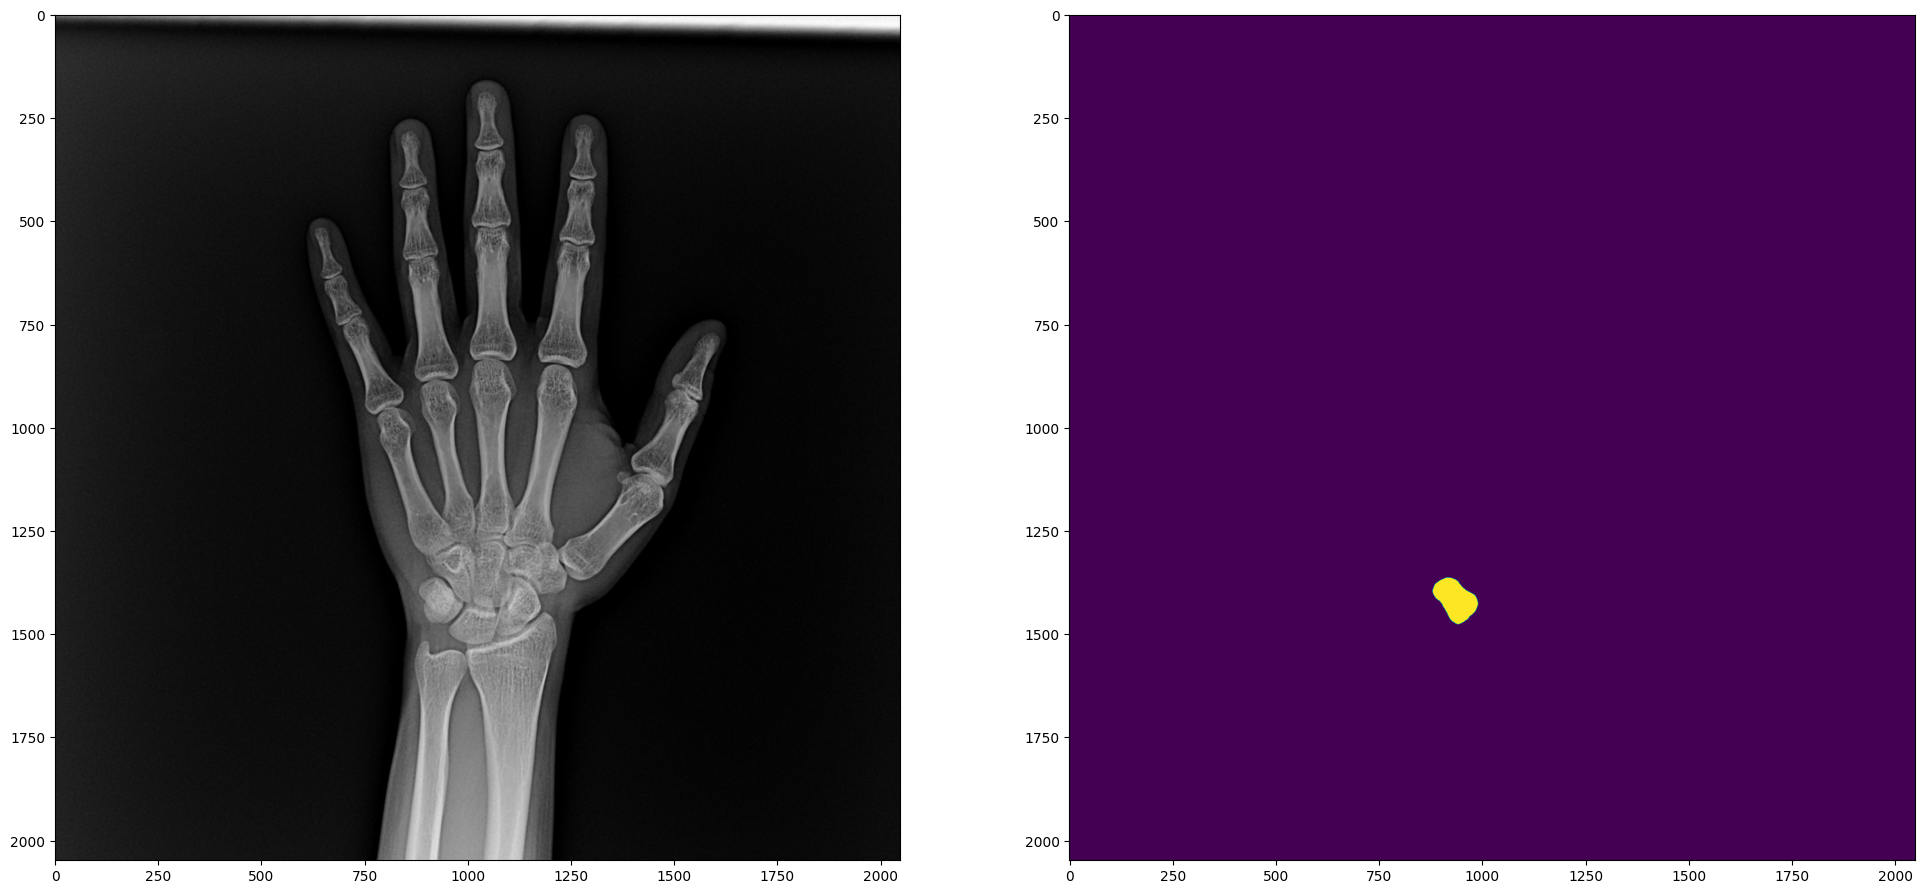

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image) 
ax[1].imshow(label)


In [96]:
df = pd.DataFrame({
    "image_name": filenames,
    "class": ['Triquetrum']*len(filenames),
    "rle": rles,
})

In [98]:
merged_df = df_input.merge(df, on=['image_name', 'class'], how='left', suffixes=('_df1', '_df2'))
merged_df['rle'] = merged_df['rle_df2'].combine_first(merged_df['rle_df1'])
final_df = merged_df[['image_name', 'class', 'rle']]


In [ ]:
# final_df.to_csv("./output_9750_crop_Triquetrum_tta.csv", index=False)

In [39]:
df_ham = pd.read_csv('./output_9750_crop_Hamate_tta.csv')

In [43]:
df_pis = pd.read_csv('./output_9750_crop_Pisiform_tta.csv')

In [45]:
df_trapezisum = pd.read_csv('./output_9750_crop_Trapezium_tta.csv')

In [46]:
df_trapezoid = pd.read_csv('./output_9750_crop_Trapezoid_tta.csv')

In [47]:
merged_df = df_input.merge(df_ham, on=['image_name', 'class'], how='left', suffixes=('_df1', '_df2'))
merged_df['rle'] = merged_df['rle_df2'].combine_first(merged_df['rle_df1'])
merged_df1 = merged_df[['image_name', 'class', 'rle']]


In [49]:
CLASS2IND['Hamate']

22

In [51]:
df_input.iloc[22]

image_name                               image1661319116107.png
class                                                    Hamate
rle           2962480 11 2964516 27 2966562 32 2968582 7 296...
image_path                         ID040_image1661319116107.png
Name: 22, dtype: object

In [50]:
merged_df1.iloc[22]

image_name                               image1661319116107.png
class                                                    Hamate
rle           2968614 10 2970657 23 2972699 31 2974742 37 29...
Name: 22, dtype: object

In [53]:
CLASS2IND['Pisiform']

26

In [52]:
merged_df2 = merged_df1.merge(df_pis, on=['image_name', 'class'], how='left', suffixes=('_df1', '_df2'))
merged_df2['rle'] = merged_df2['rle_df2'].combine_first(merged_df2['rle_df1'])
merged_df2 = merged_df2[['image_name', 'class', 'rle']]


In [54]:
merged_df2.iloc[26]

image_name                               image1661319116107.png
class                                                  Pisiform
rle           3193924 7 3195967 18 3198012 24 3200059 26 320...
Name: 26, dtype: object

In [55]:
df_input.iloc[26]

image_name                               image1661319116107.png
class                                                  Pisiform
rle           3191876 2 3193921 9 3195966 15 3198012 19 3200...
image_path                         ID040_image1661319116107.png
Name: 26, dtype: object

In [56]:
merged_df3 = merged_df2.merge(df_trapezisum, on=['image_name', 'class'], how='left', suffixes=('_df1', '_df2'))
merged_df3['rle'] = merged_df3['rle_df2'].combine_first(merged_df3['rle_df1'])
merged_df3 = merged_df3[['image_name', 'class', 'rle']]


In [59]:
CLASS2IND['Trapezium']

19

In [61]:
merged_df3.iloc[19]

image_name                               image1661319116107.png
class                                                 Trapezium
rle           2974512 9 2974524 14 2976558 31 2978604 35 298...
Name: 19, dtype: object

In [60]:
df_input.iloc[19]

image_name                               image1661319116107.png
class                                                 Trapezium
rle           2974531 7 2976575 14 2978597 1 2978611 2 29786...
image_path                         ID040_image1661319116107.png
Name: 19, dtype: object

In [57]:
merged_df4 = merged_df3.merge(df_trapezoid, on=['image_name', 'class'], how='left', suffixes=('_df1', '_df2'))
merged_df4['rle'] = merged_df4['rle_df2'].combine_first(merged_df4['rle_df1'])
merged_df4 = merged_df4[['image_name', 'class', 'rle']]


In [62]:
CLASS2IND['Trapezoid']

20

In [65]:
merged_df4.iloc[20]

image_name                               image1661319116107.png
class                                                 Trapezoid
rle           3005259 17 3007305 25 3009351 32 3011398 35 30...
Name: 20, dtype: object

In [64]:
df_input.iloc[20]

image_name                               image1661319116107.png
class                                                 Trapezoid
rle           2992981 1 2995028 4 2997074 8 2999120 12 30011...
image_path                         ID040_image1661319116107.png
Name: 20, dtype: object

In [67]:
merged_df4.to_csv("./output_9750_crop_Ham_Pis_Trapezium_Trapezoid.csv", index=False)